# 0.0 Imports

In [27]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import inflection
import pickle 
import flask

from scipy import stats as ss
from numpy import log as ln
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from skopt import BayesSearchCV
from xgboost import XGBClassifier


In [28]:
warnings.filterwarnings("ignore", category=FutureWarning)

## 0.1 Helper Functions

In [153]:
def variable_univariada(coluna, dataset):
    df_aux = dataset[[coluna,'response']].groupby(coluna).count().reset_index(drop = False)
    df_aux['total'] = df_aux['response'].sum()
    df_aux['percentage'] = df_aux['response'] / df_aux['total']
    figure = sns.barplot(x=coluna, y='percentage', data=df_aux) 
    return figure

def iv_table(coluna, filtro):
    df_result = pd.crosstab(df4[coluna], df4['response']).reset_index(drop = False)

    df_result.columns = [coluna,'Não Interessado', 'Interessado']
    df_result
    df_result['Total'] = df_result.apply(lambda x: x['Não Interessado'] + x['Interessado'], axis = 1)
    df_result['Total %'] = df_result.apply(lambda x: x['Total'] / df_result['Total'].sum(), axis = 1)
    df_result['% Sim'] = df_result.apply(lambda x: x['Interessado'] / df_result['Interessado'].sum(), axis = 1)
    df_result['% Não'] = df_result.apply(lambda x: x['Não Interessado'] / df_result['Não Interessado'].sum(), axis = 1)
    df_result['Probabilidade de Interesse'] = np.round(df_result.apply(lambda x: x['Interessado'] / x['Total'], axis = 1), 4) * 100
    df_result['IV'] = df_result.apply(lambda x: (x['% Sim'] - x['% Não']) * ln(x['% Sim'] / x['% Não']), axis=1)
    if filtro == 1:
        display(df_result)
    else:

        titulo = coluna.replace('_', ' ').title()

        plt.figure(figsize=(20, 5))

        plt.subplot(1, 2, 1)
        sns.barplot(x=coluna, y="Interessado", data=df_result, color="green", label="Interessado")
        sns.barplot(x=coluna, y="Não Interessado", data=df_result, color="red", label="Não Interessado", bottom=df_result["Interessado"])

        plt.xlabel(titulo)
        plt.ylabel("Quantidade de Pessoas")
        plt.title(f"Quantidade de Pessoas x {titulo}")

        plt.subplot(1, 2, 2)
        sns.barplot(x= coluna, y= 'Probabilidade de Interesse', palette='dark:green', hue = 'Probabilidade de Interesse',  data = df_result)

        plt.xlabel(titulo)
        plt.title(f"Probabilidade de Interesse x {titulo}")

def precision_at_k (data, predicted, k= 9150):

    # propensity score
    data['score'] = predicted[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values('score', ascending=False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking column
    data['ranking'] = data.index + 1

    # precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']


    return data.loc[k, 'precision_at_k']

def recall_at_k (data, predicted, k= 9150):

    # propensity score
    data['score'] = predicted[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values('score', ascending=False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking column
    data['ranking'] = data.index + 1

    # recall_at_k at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def metrics(data, predicted, k=9150):
    precision = precision_at_k(data, predicted, k)
    recall = recall_at_k(data, predicted, k)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1_score

def custom_scorer_precision(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    data = pd.DataFrame({'response': y, 'score': y_pred[:, 1]})
    return precision_at_k(data, y_pred, k=9150)

def custom_scorer_recall(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    data = pd.DataFrame({'response': y, 'score': y_pred[:, 1]})
    return recall_at_k(data, y_pred, k=9150)

def custom_scorer_f1_score(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    data = pd.DataFrame({'response': y, 'score': y_pred[:, 1]})

    precision = precision_at_k(data, y_pred, k = 9150)
    recall = recall_at_k(data, y_pred, k = 9150)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

def numerical_attributes(numerical):
    # Central Tendecy (Mean and Median)
    c1 = pd.DataFrame(numerical.apply(lambda x: np.mean(x)))
    c2 = pd.DataFrame(numerical.apply(lambda x: np.median(x)))

    # Dispersion
    d1 = pd.DataFrame(numerical.apply(lambda x: (x).min()))
    d2 = pd.DataFrame(numerical.apply(lambda x: (x).max()))
    d3 = pd.DataFrame(numerical.apply(lambda x: (x).max() - (x).min()))
    d4 = pd.DataFrame(numerical.apply(lambda x: np.std(x)))
    d5 = pd.DataFrame(numerical.apply(lambda x: (x).skew()))
    d6 = pd.DataFrame(numerical.apply(lambda x: (x).kurtosis()))

    a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
    a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']

    return a

## 0.2 Loading Dataset

In [30]:
df_raw = pd.read_csv('dataset/train.csv')

# 1.0 Análise Descritiva

In [31]:
x_aux = df_raw.drop(['Response'], axis = 1)
y_aux = df_raw['Response']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_aux, y_aux, test_size=0.20, stratify=y_aux, random_state=42)
df1 = pd.concat([x_train, y_train], axis = 1)

In [33]:
df_test = pd.concat([x_test, y_test], axis = 1)

In [85]:
df1.shape

(304887, 12)

## 1.1 Rename Columns

In [34]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage','Response']
cols_new = [inflection.underscore(col) for col in cols_old]
df1.columns = cols_new


## 1.2 Dataset Size

In [35]:
print(f'Linhas: {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas: 304887
Colunas: 12


## 1.3 DataTypes

In [36]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [37]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Estatística Descritiva

In [38]:
numerical = df1.select_dtypes(include = ['int64', 'float64'])
categorical = df1.select_dtypes(exclude = ['int64', 'float64'])
numerical_attributes(numerical)


,min,max,range,mean,median,std,skew,kurtosis
id,1.0,381109.0,381108.0,190738.657112,190886.0,110004.186837,-0.001457,-1.199436
age,20.0,85.0,65.0,38.826897,36.0,15.515274,0.671710,-0.568526
driving_license,0.0,1.0,1.0,0.997855,1.0,0.046265,-21.521960,461.197806
region_code,0.0,52.0,52.0,26.396239,28.0,13.228728,-0.115538,-0.866961
previously_insured,0.0,1.0,1.0,0.458127,0.0,0.498244,0.168083,-1.971761
annual_premium,2630.0,540165.0,537535.0,30591.308311,31697.0,17239.257418,1.721299,32.191697
policy_sales_channel,1.0,163.0,162.0,112.053859,134.0,54.189199,-0.900677,-0.969360
vintage,10.0,299.0,289.0,154.392214,154.0,83.670175,0.002134,-1.200642
response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301907,3.298797


### 1.5.2 Categorical Attributes

<Axes: xlabel='vehicle_damage', ylabel='count'>

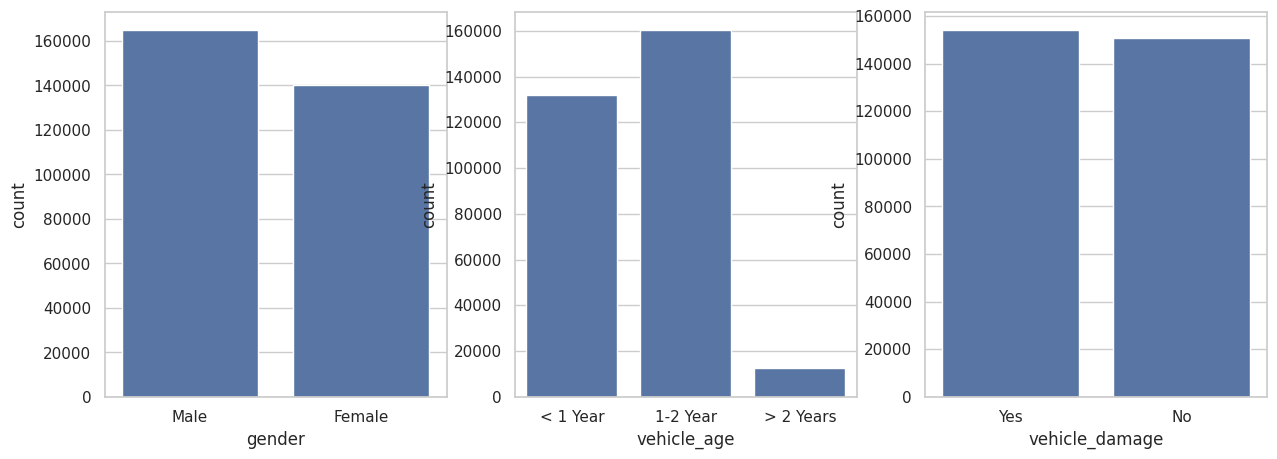

In [94]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.countplot(x='gender', data= categorical)

plt.subplot(1, 3, 2)
sns.countplot(x='vehicle_age', data= categorical)

plt.subplot(1, 3, 3)
sns.countplot(x='vehicle_damage', data= categorical)


# 2.0 Feature Engineering

In [40]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

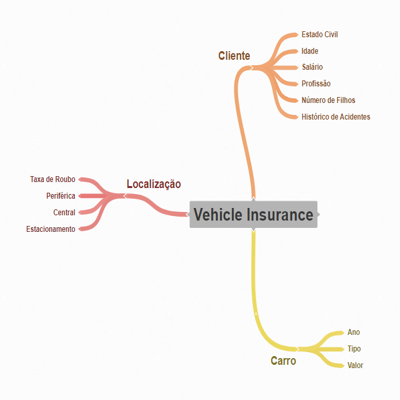

In [41]:
img = Image.open('img/mind_map.png')
img = img.convert('RGB')
img.resize((400, 400)).show()


## 2.2 Hipóteses

### 2.2.1 Localização
1. Clientes que moram em regiões com maior taxa de roubo podem ser mais provavéis a aderir ao seguro de veículo.
2. Clientes que trabalham em regiões com maior disponibilidade de estacionamentos deveriam ter menor interesse em adquirir o seguro de carro.
3. Clientes que moram em regiões específicas podem ter maior interesse no seguro.

### 2.2.2 Clientes
1. Clientes com salário maior são mais provavéis de adquirir o seguro.
2. Clientes que são casados podem ter maior interesse em adquirir o seguro de carro.
3. Clientes que tem histórico de acidentes podem ter maior interesse em adquirir o seguro de veículo.
4. Clientes que não tem seguro de carro podem estar mais interessados em um seguro de veículo.
5. Clientes há mais tempo são mais prováveis de adquirirem o seguro.
6. A idade pode ser um fator diferencial, com clientes mais jovens tendo menos interesse.
7. O gênero do cliente pode ser um fator importante na aquisição do seguro.
8. Diferentes métodos de contato podem impactar o interesse em seguro de veículos.

### 2.2.3 Carros
1. O tipo do carro pode influenciar o interesse do cliente no seguro.
2. Clientes com carros novos podem ter maior interesse em aderir ao seguro de carro.
3. Clientes com carros mais caros são mais prováveis de adquirerem o seguro.



## 2.3 Lista Final
1. Clientes que tem histórico de acidentes podem ter maior interesse em adquirir o seguro de veículo.
2. Clientes que não tem seguro de carro podem estar mais interessados em um seguro de veículo.
3. Clientes há mais tempo são mais prováveis de adquirirem o seguro.
4. A idade pode ser um fator diferencial, com clientes mais jovens tendo menos interesse.
5. Clientes com carros novos podem ter maior interesse em aderir ao seguro de carro.
6. O gênero do cliente pode ser um fator importante na aquisição do seguro.
7. Clientes que moram em regiões específicas podem ter maior interesse no seguro.
8. Diferentes métodos de contato podem impactar o interesse em seguro de veículos.
9. O valor cobrado pode impactar no interesse do seguro de veículo.
10. Clientes que tem CNH são mais prováveis de adquirir o seguro.

## 2.4 Feature Engineering

In [42]:
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')


# 3.0 Filtragem de Variáveis

In [43]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [44]:
df4 = df3.copy()

<Axes: xlabel='response', ylabel='count'>

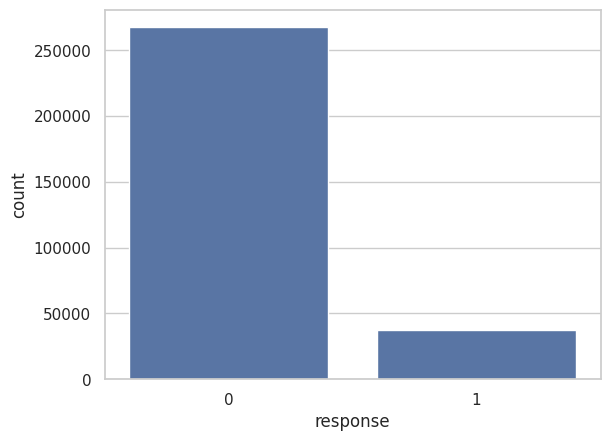

In [95]:
sns.countplot(x= 'response', data = df4)

## 4.1 Análise Univariada

<Axes: xlabel='age', ylabel='Count'>

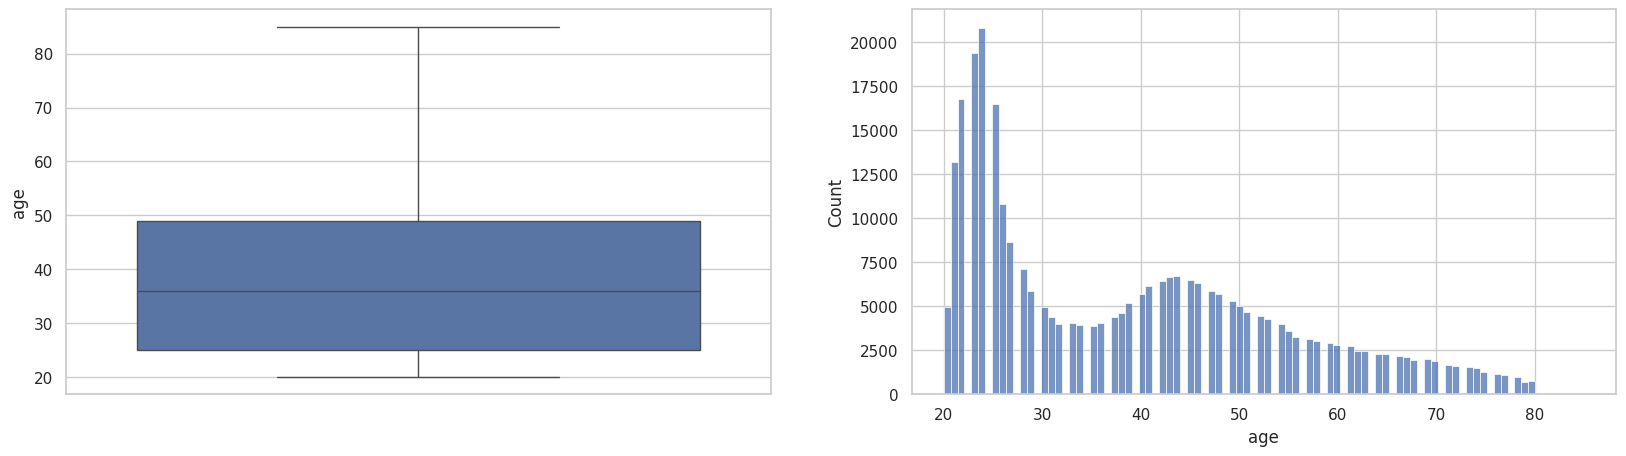

In [99]:
# age
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.boxplot( y='age', data = df4)

plt.subplot(1, 2, 2)
sns.histplot(x='age', data = df4)




<Axes: xlabel='annual_premium', ylabel='Count'>

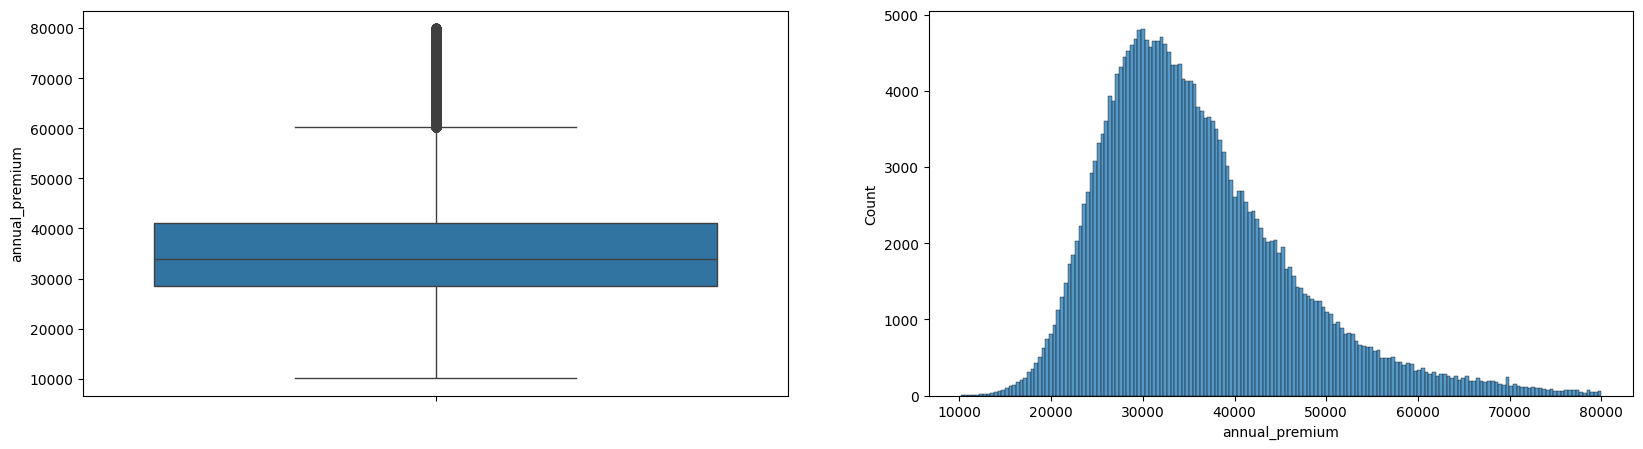

In [46]:
# annual_premium
df_aux1 = df4.loc[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000),['response', 'annual_premium']]
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.boxplot( y='annual_premium', data = df_aux1)

plt.subplot(1, 2, 2)
sns.histplot( x='annual_premium', data = df_aux1)

<Axes: xlabel='vintage', ylabel='Count'>

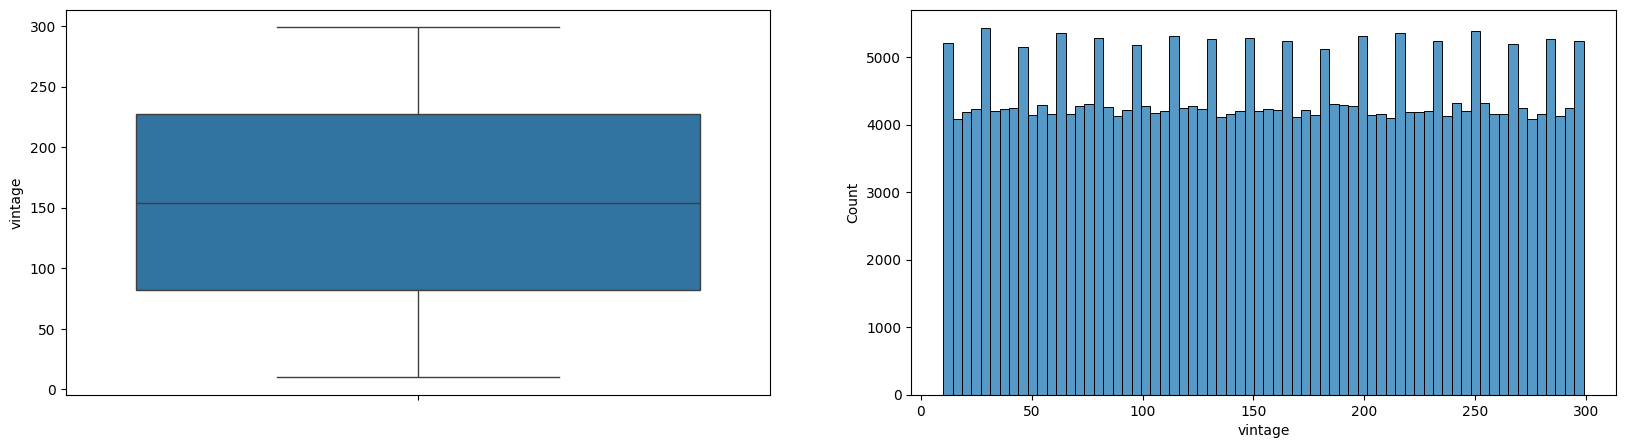

In [47]:
# vintage
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.boxplot(y='vintage', data = df4)

plt.subplot(1, 2, 2)
sns.histplot(x='vintage', data = df4)



<Axes: xlabel='previously_insured', ylabel='Count'>

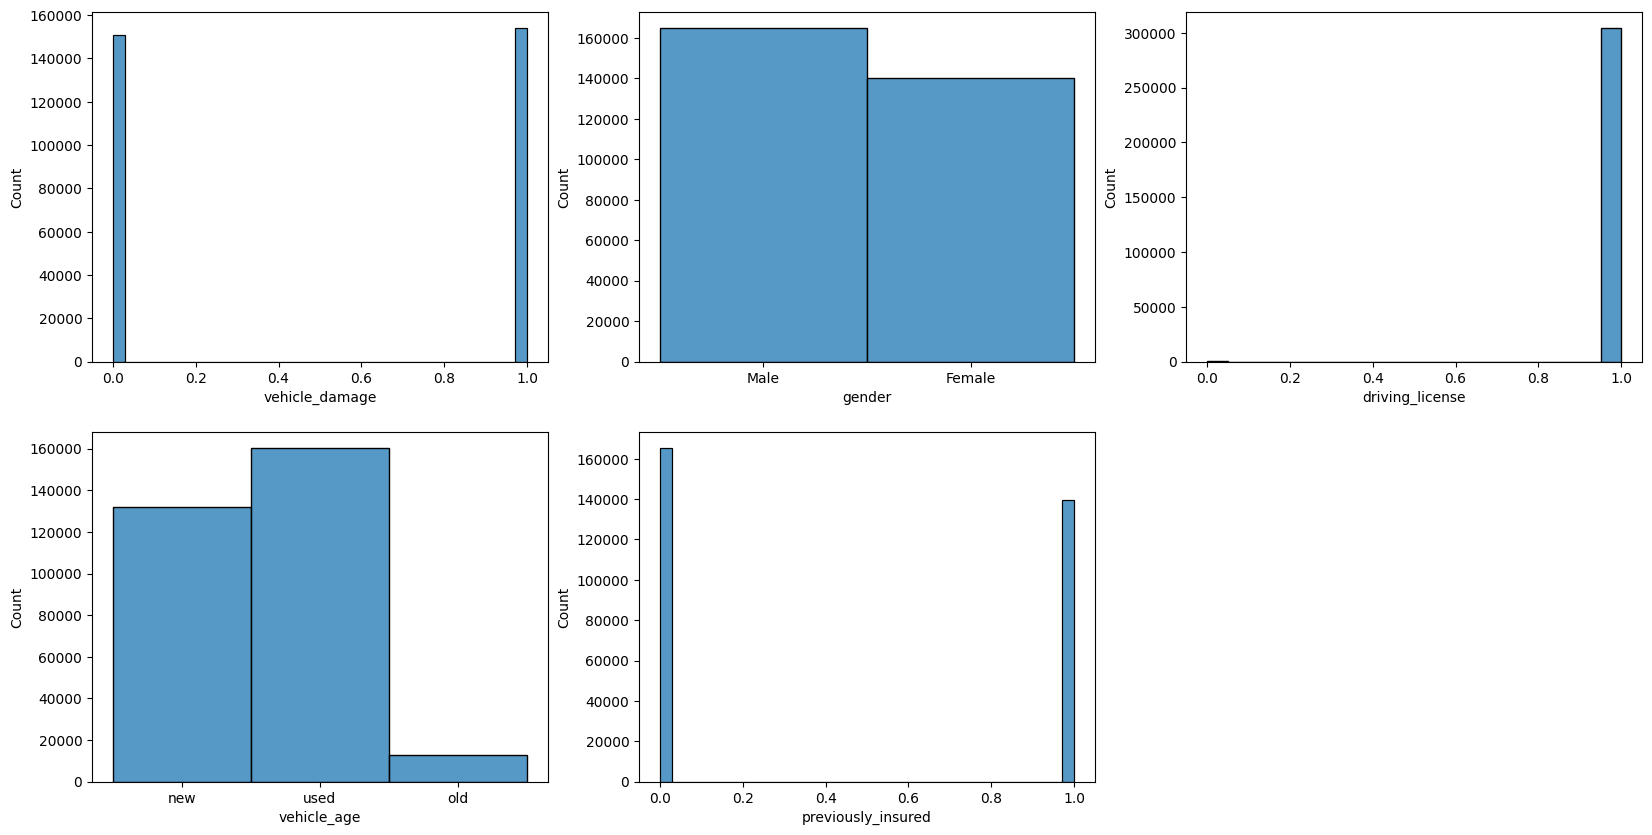

In [48]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
sns.histplot(x = 'vehicle_damage', data = df4)

plt.subplot(2, 3, 2)
sns.histplot(x = 'gender', data = df4)

plt.subplot(2, 3, 3)
sns.histplot(x = 'driving_license', data = df4)

plt.subplot(2, 3, 4)
sns.histplot(x = 'vehicle_age', data = df4)

plt.subplot(2, 3, 5)
sns.histplot(x = 'previously_insured', data = df4)

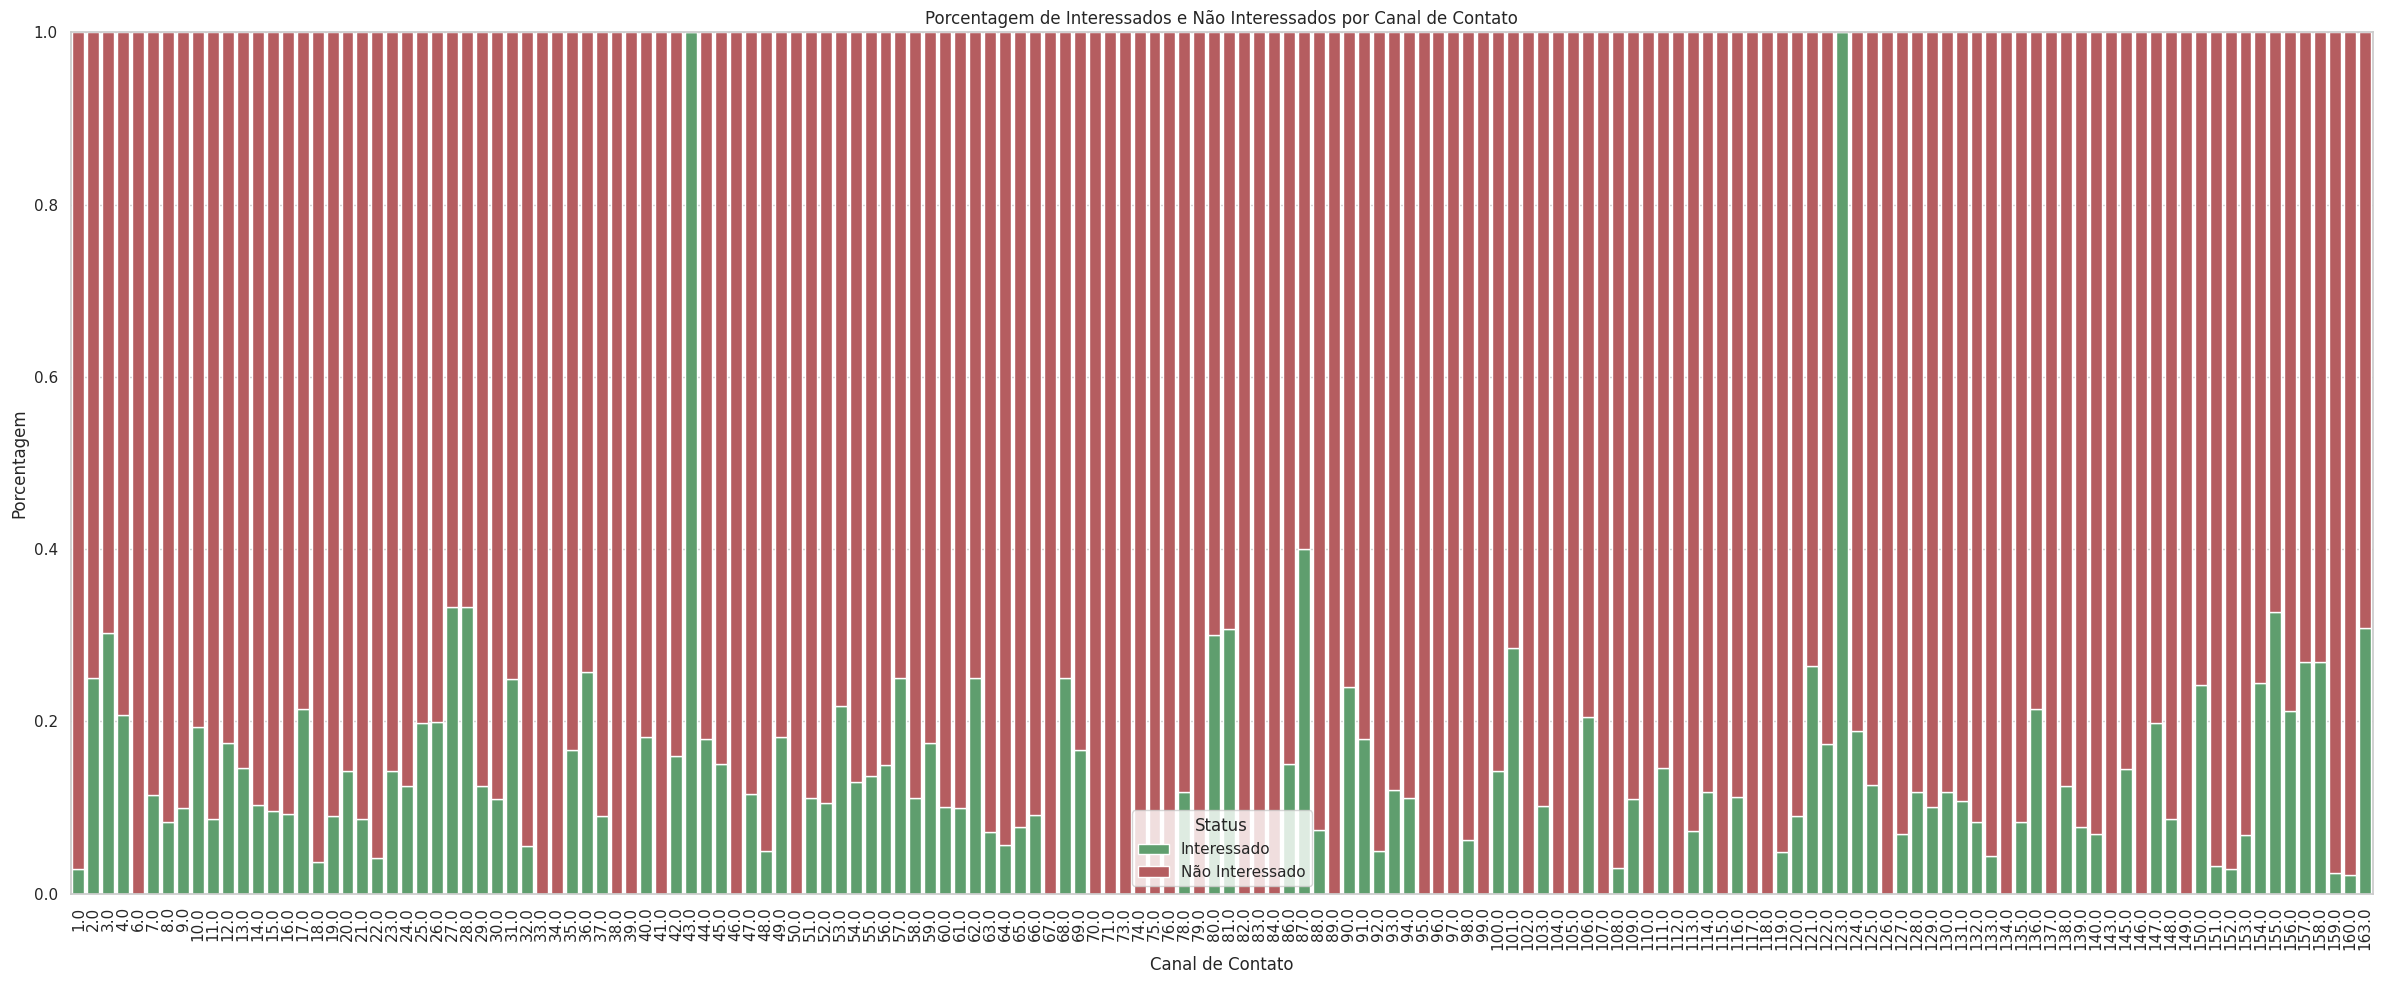

In [49]:
# 'policy_sales_channel'

# Agregue os dados para calcular as porcentagens de interessados e não interessados para cada canal de contato.
dados_agrupados = df4.groupby('policy_sales_channel')['response'].value_counts(normalize=True).unstack().fillna(0)

# Crie um gráfico empilhado de barras com as porcentagens.
plt.figure(figsize=(24, 10))
sns.set(style="whitegrid")
sns.barplot(x=dados_agrupados.index, y=dados_agrupados[1], color='g', label='Interessado')
sns.barplot(x=dados_agrupados.index, y=dados_agrupados[0], color='r', label='Não Interessado', bottom=dados_agrupados[1])

# Personalize o gráfico com rótulos, título, etc.
plt.xlabel('Canal de Contato')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de Interessados e Não Interessados por Canal de Contato')
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor legibilidade.
plt.legend(title='Status')

# Exiba o gráfico.
plt.tight_layout()
plt.show()


<Axes: xlabel='region_code', ylabel='id'>

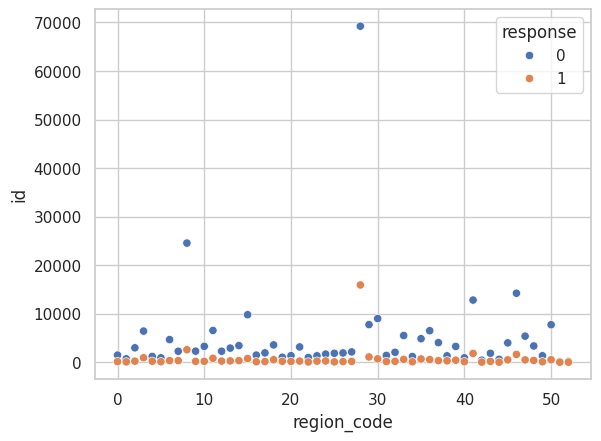

In [50]:
# region_code
df_aux = df4[['id','response','region_code']].groupby(['response','region_code']).count()
sns.scatterplot(x='region_code', y='id', hue='response', data= df_aux)

## 4.2 Análise Bivariada

### H1. Clientes que tem histórico de acidentes podem ter maior interesse em adquirir o seguro de veículo.
**VERDADEIRO** O fator histórico de acidentes contribui significamente para o interesse do cliente.




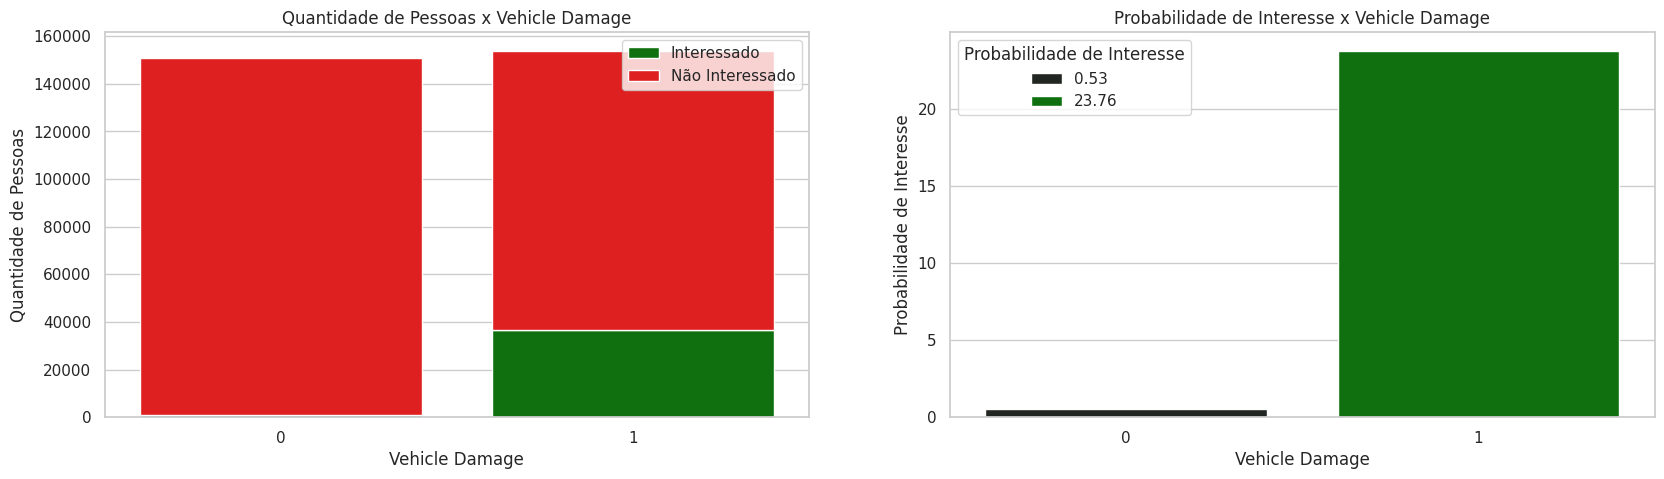

In [51]:
# vehicle_damage
iv_table('vehicle_damage', 0)

### H2. Clientes que não tem seguro de carro podem estar mais interessados em um seguro de veículo.
**VERDADEIRO** Clientes que não tem seguro são mais interessados no seguro de carro.


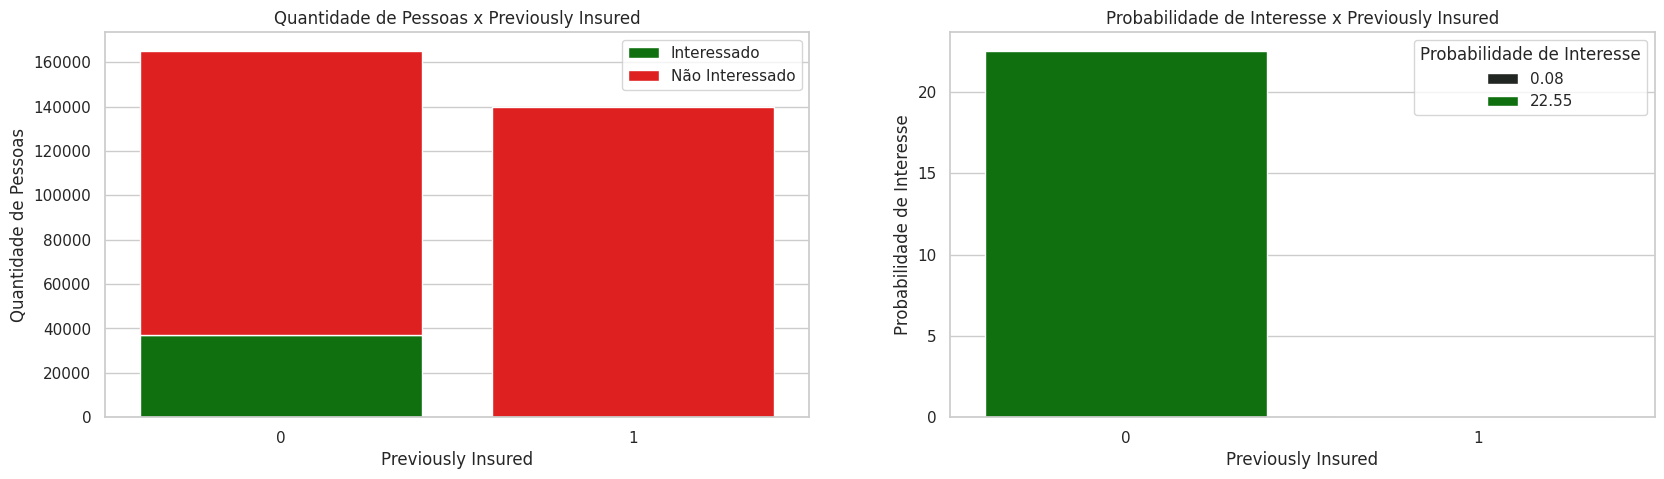

In [52]:
iv_table('previously_insured', 0)


### H3. Clientes há mais tempo são mais prováveis de adquirirem o seguro, devido a sua experiência com a empresa.
**FALSO** A longevidade dos clientes na base não interfere na decisão de adquirir o seguro.


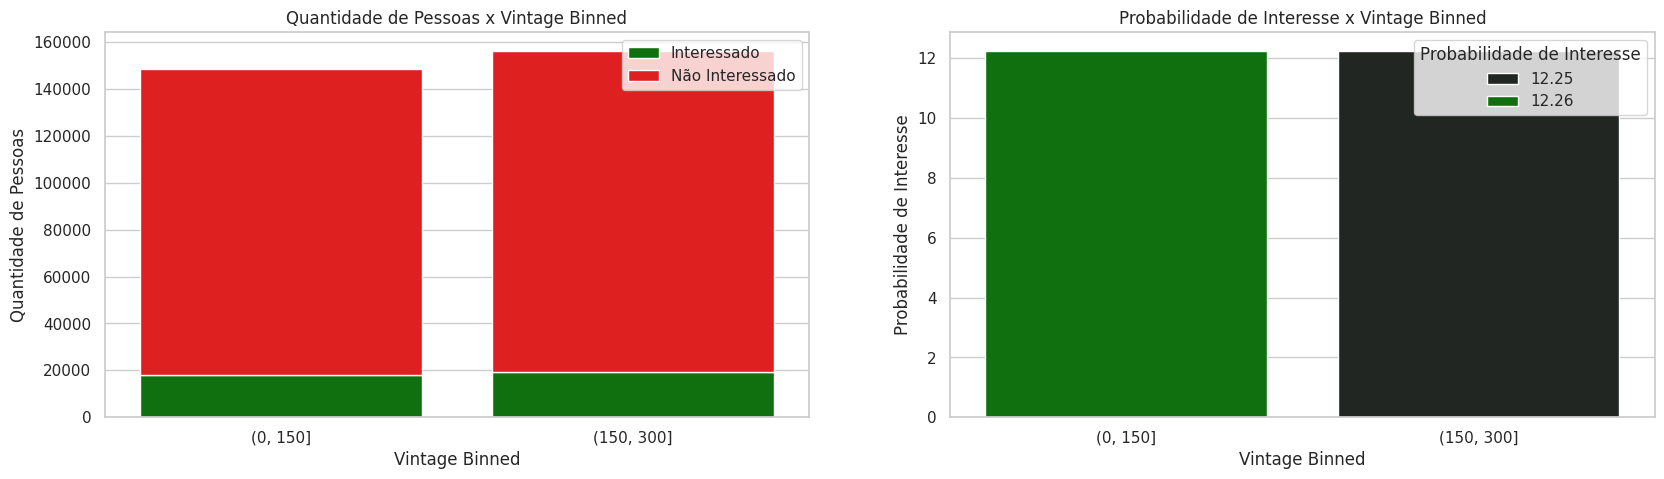

In [53]:
# vintage
lista = (0, 150, 300)
df4['vintage_binned'] = pd.cut(df4['vintage'], bins = lista)

iv_table('vintage_binned', 0)

### H4. A idade pode ser um fator diferencial, com clientes mais jovens tendo menos interesse.
**VERDADEIRO** Clientes com idade entre 35 e 50 são os mais interessados.


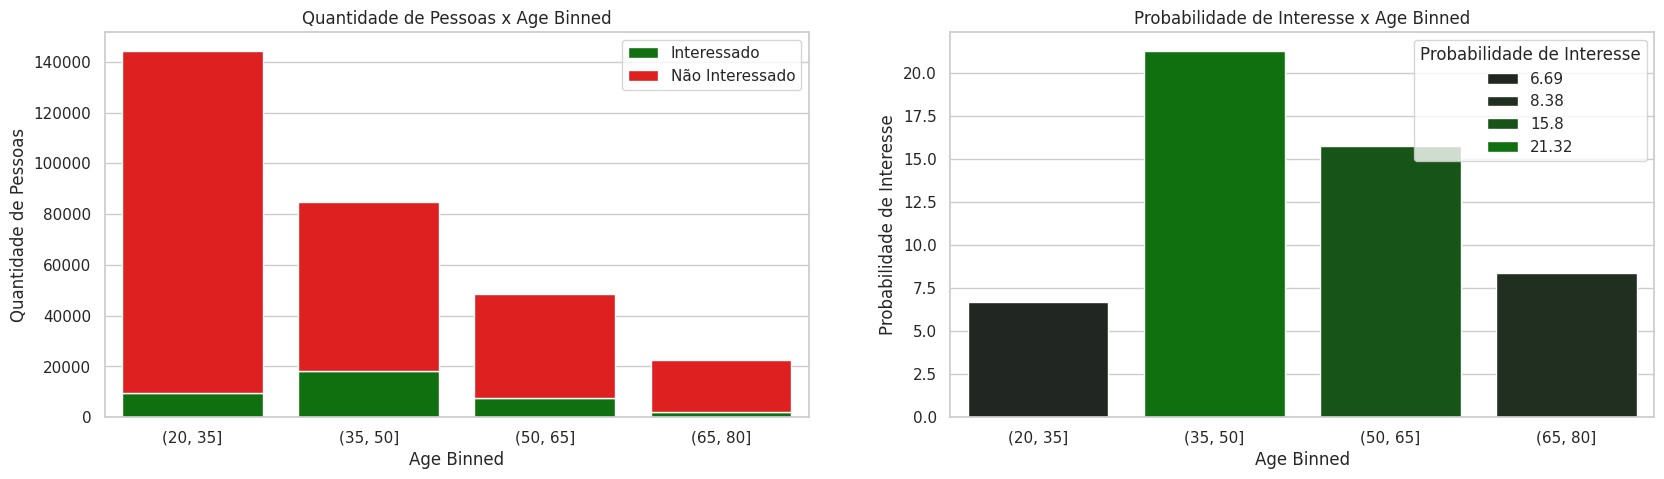

In [54]:
# age_binned
lista = np.arange(20, 81, 15)
df4['age_binned'] = pd.cut(df4['age'], bins = lista)

iv_table('age_binned', 0)

### H5. Clientes com carros novos podem ter maior interesse em aderir ao seguro de carro.
**FALSO** Clientes com carros usados e velhos tem maior interesse.

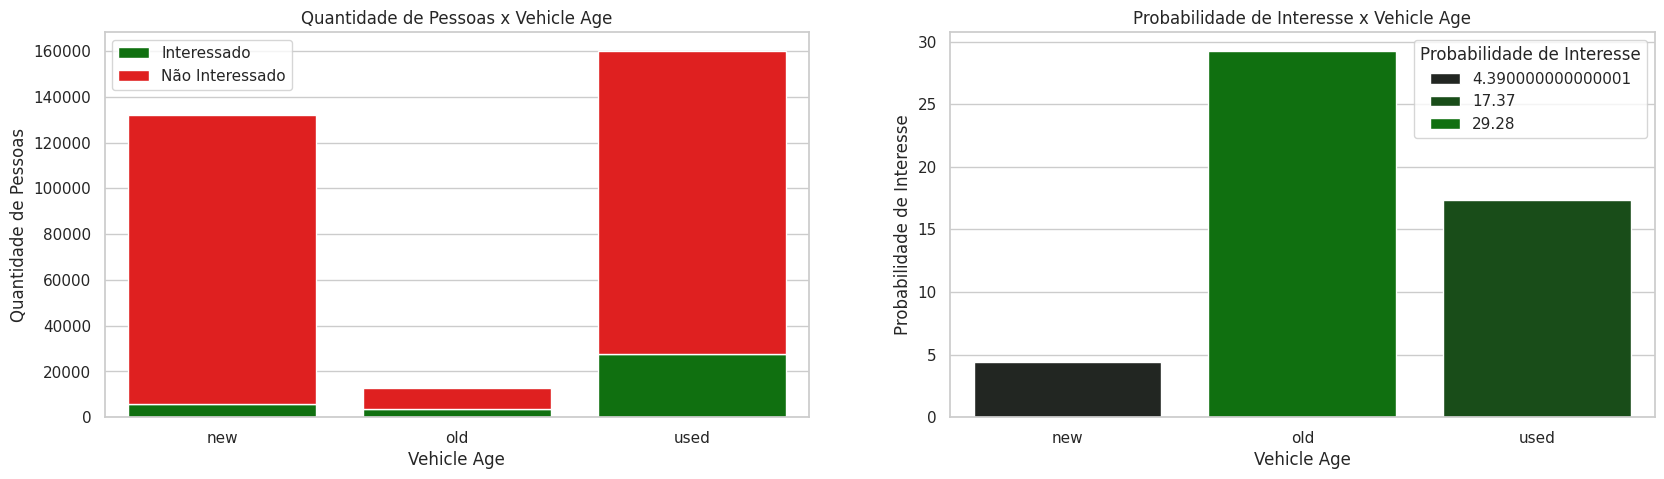

In [55]:
iv_table('vehicle_age', 0)

#### H5.2 Explicação

Text(0.5, 0, 'Condição')

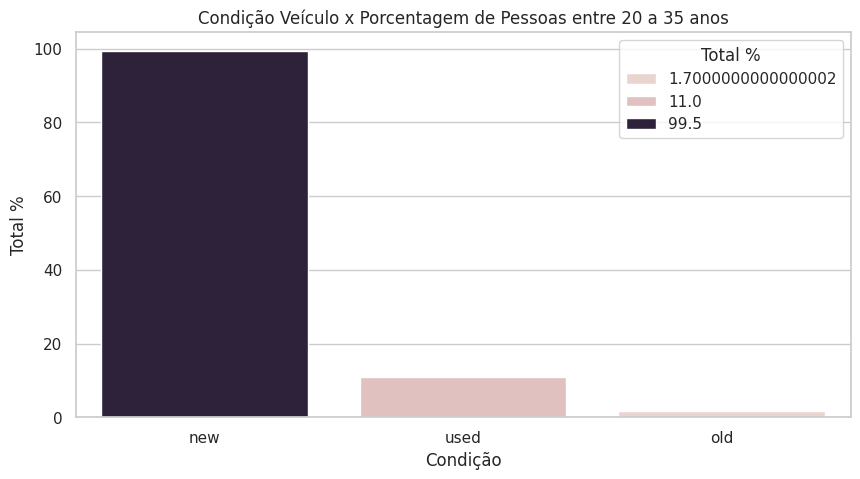

In [56]:
cols = df4['vehicle_age'].unique()
dfs = []
for coluna in cols:
    df_aux = df4.loc[df4['vehicle_age'] == coluna, :]
    df_result = pd.crosstab(df_aux['age_binned'], df_aux['response']).reset_index(drop=False)
    df_result.columns = [f'Age_Binned','Não Interessado', 'Interessado']

    df_result['Type'] = coluna
    df_result['Total'] = df_result.apply(lambda x: x['Não Interessado'] + x['Interessado'], axis = 1)
    df_result['Total %'] = df_result.apply(lambda x: x['Total'] / df_result['Total'].sum(), axis = 1)
    df_result['% Sim'] = df_result.apply(lambda x: x['Interessado'] / df_result['Interessado'].sum(), axis = 1)
    df_result['% Não'] = df_result.apply(lambda x: x['Não Interessado'] / df_result['Não Interessado'].sum(), axis = 1)
    df_result['Probabilidade de Interesse'] = np.round(df_result.apply(lambda x: x['Interessado'] / x['Total'], axis = 1), 4) * 100
    df_result['IV'] = df_result.apply(lambda x: (x['% Sim'] - x['% Não']) * ln(x['% Sim'] / x['% Não']), axis=1)

    dfs.append(df_result)

# Concatenar todos os DataFrames em um único DataFrame consolidado
df_consolidated = pd.concat(dfs, ignore_index=True)

df_testando = df_consolidated.loc[[0, 4, 8],:]
df_testando['Total %'] = np.round(df_testando['Total %'], 3) * 100
plt.figure(figsize=(10, 5))

sns.barplot(x = 'Type', y = 'Total %', hue = 'Total %', data = df_testando )
plt.title('Condição Veículo x Porcentagem de Pessoas entre 20 a 35 anos')
plt.xlabel('Condição')


### H6. O gênero do cliente pode ser um fator importante na aquisição do seguro.
**FALSO** Não tem uma grande diferença de interesse.


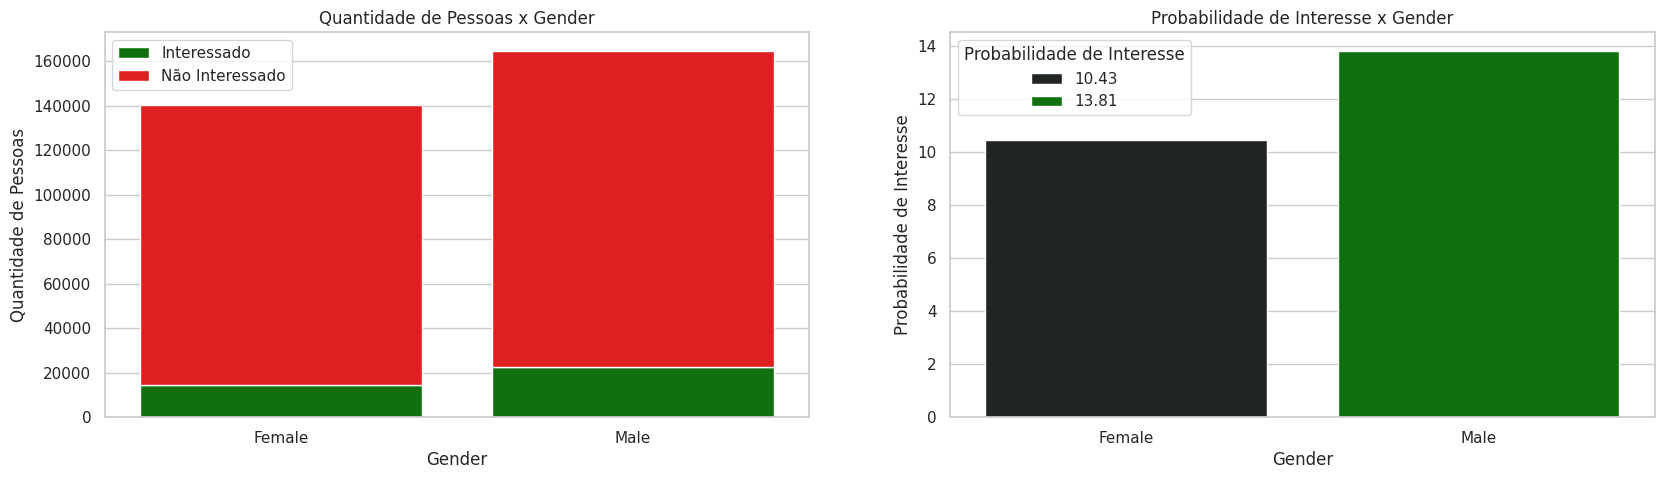

In [57]:
iv_table('gender', 0)

### H7. Clientes que moram em regiões específicas podem ter maior interesse no seguro.
***VERDADEIRO*** Pessoas que moram na região 28 tem maior interesse no seguro.

Text(0.5, 1.0, 'Probabilidade de Interesse x Region Code')

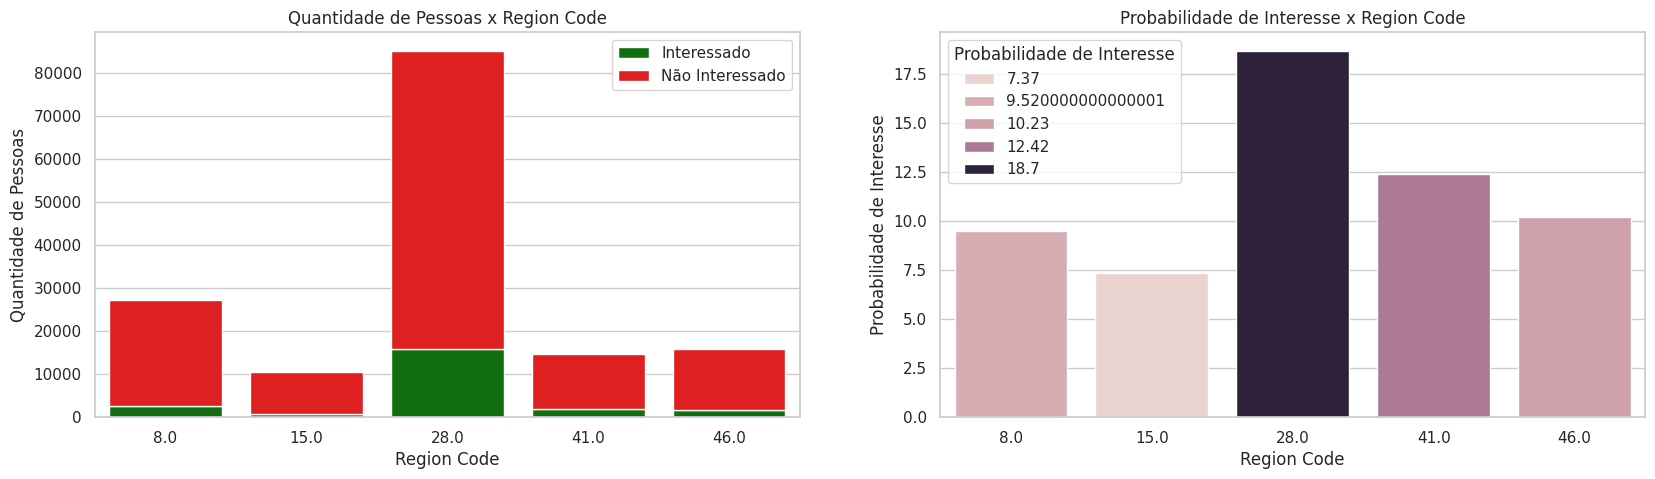

In [135]:
df_aux = df4[df4['region_code'].isin(df4['region_code'].value_counts()[df4['region_code'].value_counts() > 10000].index)]

df_result = pd.crosstab(df_aux['region_code'], df_aux['response']).reset_index(drop = False)

df_result.columns = ['region_code','Não Interessado', 'Interessado']
df_result
df_result['Total'] = df_result.apply(lambda x: x['Não Interessado'] + x['Interessado'], axis = 1)
df_result['Total %'] = df_result.apply(lambda x: x['Total'] / df_result['Total'].sum(), axis = 1)
df_result['% Sim'] = df_result.apply(lambda x: x['Interessado'] / df_result['Interessado'].sum(), axis = 1)
df_result['% Não'] = df_result.apply(lambda x: x['Não Interessado'] / df_result['Não Interessado'].sum(), axis = 1)
df_result['Probabilidade de Interesse'] = np.round(df_result.apply(lambda x: x['Interessado'] / x['Total'], axis = 1), 4) * 100
df_result['IV'] = df_result.apply(lambda x: (x['% Sim'] - x['% Não']) * ln(x['% Sim'] / x['% Não']), axis=1)


titulo = 'region_code'.replace('_', ' ').title()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='region_code', y="Interessado", data=df_result, color="green", label="Interessado")
sns.barplot(x='region_code', y="Não Interessado", data=df_result, color="red", label="Não Interessado", bottom=df_result["Interessado"])

plt.xlabel(titulo)
plt.ylabel("Quantidade de Pessoas")
plt.title(f"Quantidade de Pessoas x {titulo}")

plt.subplot(1, 2, 2)
sns.barplot(x= 'region_code', y= 'Probabilidade de Interesse', hue = 'Probabilidade de Interesse',  data = df_result)

plt.xlabel(titulo)
plt.title(f"Probabilidade de Interesse x {titulo}")


### H8. Diferentes métodos de contato podem impactar o interesse em seguro de veículos.
***VERDADEIRO*** Os métodos de contato 26.0 e 124.0 apresentam a maior taxa de conversão de clientes interessados em seguro de veículos.

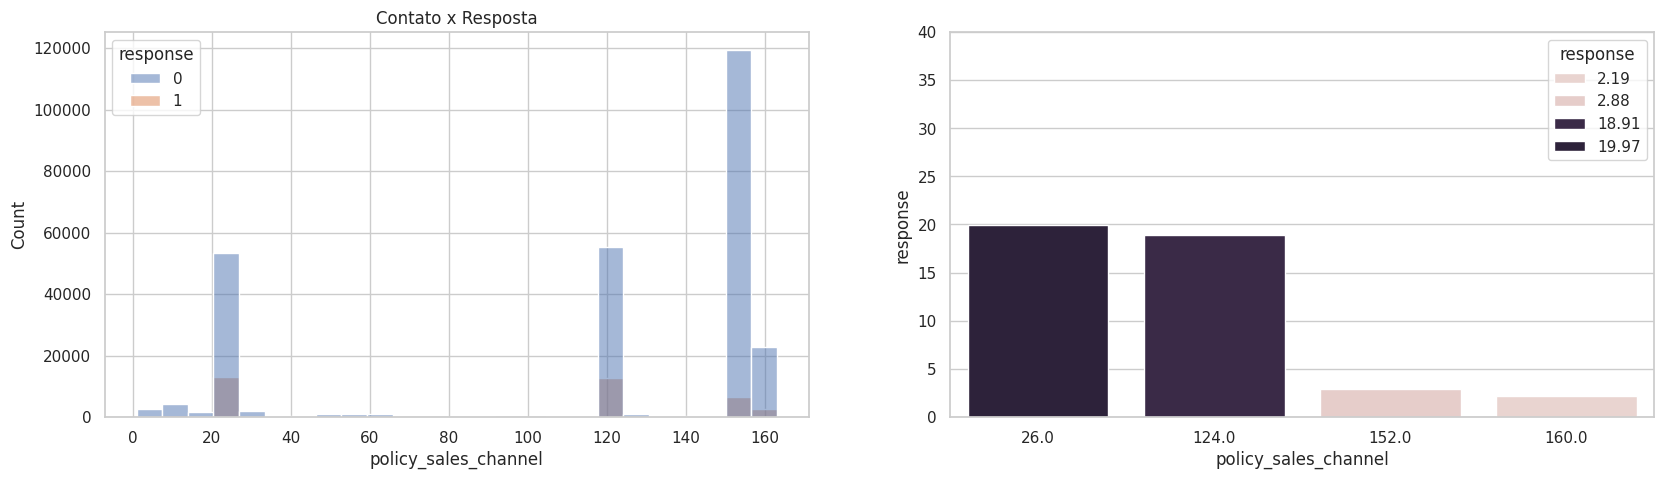

In [59]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.histplot(x='policy_sales_channel', hue='response', data=df4, bins= 25)
plt.title("Contato x Resposta")


aux = df4.loc[:, ['policy_sales_channel', 'response']].groupby('policy_sales_channel').count().sort_values('response', ascending = False).reset_index()
canais = list(aux.loc[aux['response'] > 15000, 'policy_sales_channel'])
aux = df4.loc[df4['policy_sales_channel'].isin(canais), ['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().sort_values('response', ascending = False).reset_index()
plt.subplot(1, 2, 2)
plt.ylim(0, 40)
aux['response'] = np.round(aux['response'] * 100, 2)
ax1= sns.barplot(x='policy_sales_channel', y= 'response', hue = 'response', data = aux)

### H9. O valor cobrado pode impactar no interesse do seguro de veículo.
***VERDADEIRO*** Seguros na faixa de 10000 a 20000 tem menos clientes interessados. Podendo ser devido aos benefícios não serem proporcionais ao valor cobrado.

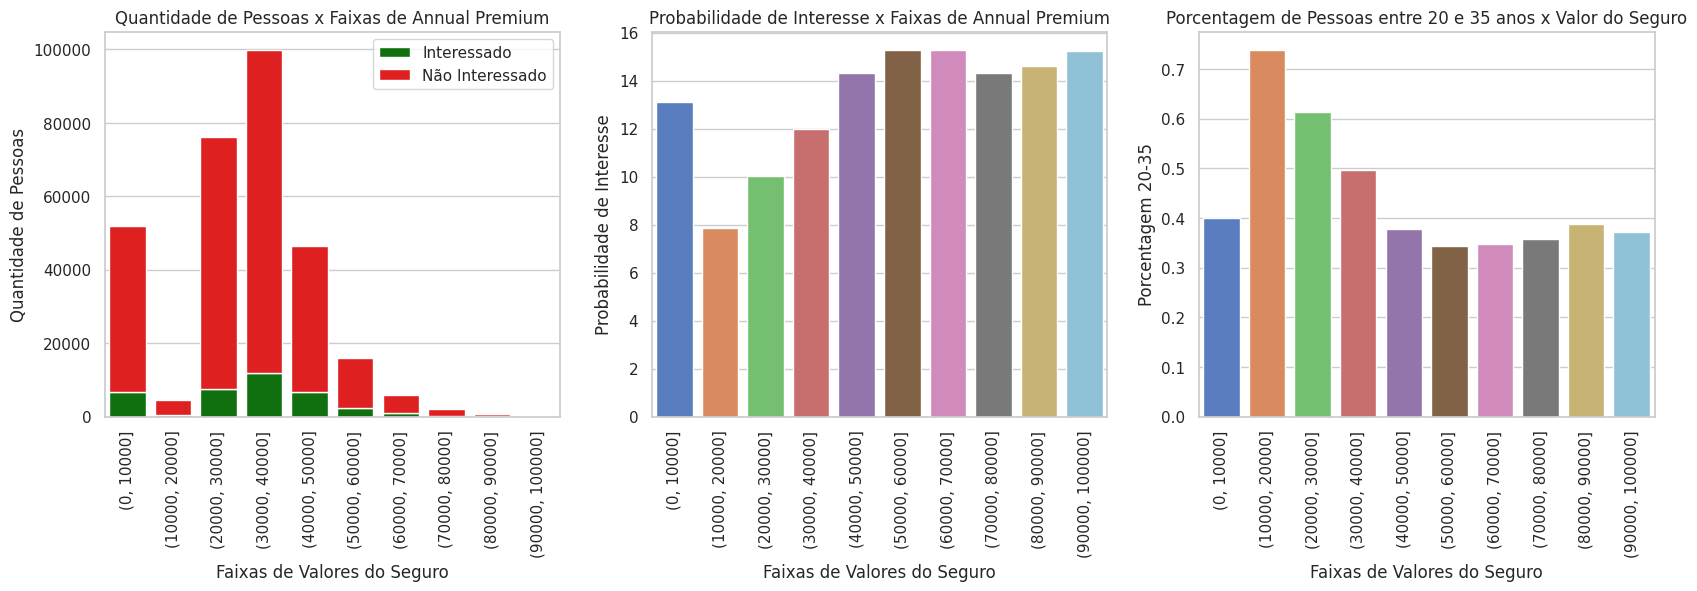

In [60]:
# annual_premium
lista = np.arange(0, 100001, 10000)
df4['annual_premium_binned'] = pd.cut(df4['annual_premium'], bins = lista)
df_result = pd.crosstab(df4['annual_premium_binned'], df4['response']).reset_index(drop = False)

df_result.columns = ['annual_premium_binned','Não Interessado', 'Interessado']

df_result['Total'] = df_result.apply(lambda x: x['Não Interessado'] + x['Interessado'], axis = 1)
df_result['Total %'] = df_result.apply(lambda x: x['Total'] / df_result['Total'].sum(), axis = 1)
df_result['% Sim'] = df_result.apply(lambda x: x['Interessado'] / df_result['Interessado'].sum(), axis = 1)
df_result['% Não'] = df_result.apply(lambda x: x['Não Interessado'] / df_result['Não Interessado'].sum(), axis = 1)
df_result['Probabilidade de Interesse'] = np.round(df_result.apply(lambda x: x['Interessado'] / x['Total'], axis = 1), 4) * 100
df_result['IV'] = df_result.apply(lambda x: (x['% Sim'] - x['% Não']) * ln(x['% Sim'] / x['% Não']), axis=1)



plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='annual_premium_binned', y="Interessado", data=df_result, color="green", label="Interessado")
sns.barplot(x='annual_premium_binned', y="Não Interessado", data=df_result, color="red", label="Não Interessado", bottom=df_result["Interessado"])

plt.xlabel('Faixas de Valores do Seguro')
plt.ylabel("Quantidade de Pessoas")
plt.title("Quantidade de Pessoas x Faixas de Annual Premium")
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.barplot(x= 'annual_premium_binned', y= 'Probabilidade de Interesse', palette='muted',  data = df_result)

plt.xlabel('Faixas de Valores do Seguro')
plt.title(f"Probabilidade de Interesse x {'Faixas de Annual Premium'}")
plt.xticks(rotation=90)


plt.subplot(1, 3, 3)
# annual premium x age
df_result = pd.crosstab(df4['annual_premium_binned'], df4['age_binned']).reset_index(drop = False)
df_result.columns = ['annual_premium','20-35', '35-50', '50-65', '65-80']
lista = ['20-35', '35-50', '50-65', '65-80']
 
df_result['Total'] = df_result.apply(lambda x: x['20-35'] + x['35-50'] + x['50-65'] + x['65-80'], axis = 1)
for coluna in lista:
    df_result[coluna] = df_result.apply(lambda x: x[coluna] / x['Total'], axis = 1)
# df_result

sns.barplot(x = 'annual_premium', y= '20-35', palette='muted', data = df_result)


plt.xlabel('Faixas de Valores do Seguro')
plt.ylabel('Porcentagem 20-35')
plt.title('Porcentagem de Pessoas entre 20 e 35 anos x Valor do Seguro')
plt.xticks(rotation=90)
plt.show()


### H10. Clientes que tem CNH são mais prováveis de adquirir o seguro.
***VERDADEIRO*** Clientes que tem CNH são mais interessados no seguro.

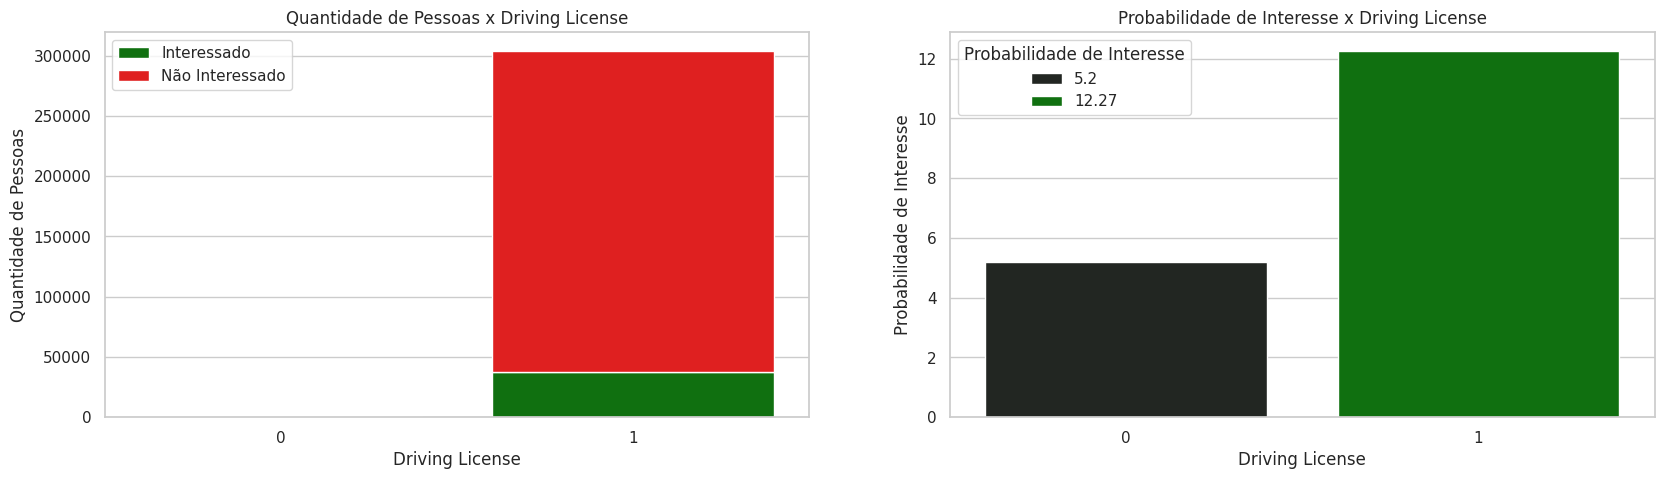

In [61]:
# driving_license
iv_table('driving_license', 0)

# 5.0 Data Preparation

In [100]:
df5 = df4.copy()

## 5.1 Standartization

In [101]:
# annual_premium
ss = StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
# pickle.dump(ss, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/ss.pkl', 'wb'))

## 5.2 Reescaling

In [102]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
# pickle.dump(mms_age, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/mms_age.pkl', 'wb'))

#vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
# pickle.dump(mms_vintage, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/mms_vintage.pkl', 'wb'))


## 5.3 Encoding

In [103]:
# # gender - Frequency
frequency_gender = df5['gender'].value_counts()/ len(df5)
frequency_gender = frequency_gender.to_dict()
df5['gender'] = df5['gender'].map(frequency_gender)

# pickle.dump(frequency_gender, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/frequency_gender.pkl', 'wb'))

# region_code - target mean

target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# pickle.dump(target_encode_region_code, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/target_encode_region_code.pkl', 'wb'))

# policy_sales_channel - target mean
target_encode_policy_sales = df5.groupby('policy_sales_channel')['response'].mean()
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(target_encode_policy_sales)

# pickle.dump(target_encode_policy_sales, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/target_encode_policy_sales.pkl', 'wb'))

# vehicle_age - target mean
target_encode_vehicle_age = df5.groupby('vehicle_age')['response'].mean()
df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age)
df5['vehicle_age'] = df5['vehicle_age'].astype(float)

# pickle.dump(target_encode_vehicle_age, open('/home/tiagobarreto/DS/repos/health-insurance1/parameter/target_encode_vehicle_age.pkl', 'wb'))

# 6.0 Feature Selection

In [104]:
df6 = df5.copy()

## 6.1 Feature Importance

In [105]:
# # define model
# forest = DecisionTreeClassifier(random_state= 42)

# # data preparation
# x_train_n = df5.drop(['id','response'], axis = 1)
# y_train_n = y_train.values

# forest.fit(x_train_n, y_train_n)

In [106]:
# importances = forest.feature_importances_
# indices = np.argsort(importances)[::-1]

# print('Feature Ranking:')
# df = pd.DataFrame()
# for i, j in zip (x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis = 0)
# print(df.sort_values('importance', ascending = False))

# 7.0 Machine Learning

In [107]:
df7 = df6.copy()

In [108]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code','policy_sales_channel', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender']


In [109]:
x_train = df7[cols_selected]


## 7.1 KNN Cross-Validation 

In [154]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_scores = cross_val_score(knn_model, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_precision)
knn_cv_precision = knn_scores.mean()

knn_scores = cross_val_score(knn_model, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_recall)
knn_cv_recall = knn_scores.mean()

knn_scores = cross_val_score(knn_model, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_f1_score)
knn_cv_f1 = knn_scores.mean()

## 7.2 Random Forest Cross-Validation

In [155]:
rf = RandomForestClassifier(random_state= 42, n_jobs= -1)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_precision)
rf_cv_precision = rf_scores.mean()

rf_scores = cross_val_score(rf, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_recall)
rf_cv_recall = rf_scores.mean()

rf_scores = cross_val_score(rf, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_f1_score)
rf_cv_f1 = rf_scores.mean()



## 7.3. Logistic Regression Cross-Validation

In [156]:
lr = LogisticRegression(random_state= 42, n_jobs= -1)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_scores = cross_val_score(lr, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_precision)
lr_cv_precision = lr_scores.mean()

lr_scores = cross_val_score(lr, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_recall)
lr_cv_recall = lr_scores.mean()

lr_scores = cross_val_score(lr, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_f1_score)
lr_cv_f1 = lr_scores.mean()

## 7.4 XGB Cross-Validation

In [157]:
xgb = XGBClassifier(random_state= 42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(xgb, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_precision)
xgb_cv_precision = xgb_scores.mean()

xgb_scores = cross_val_score(xgb, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_recall)
xgb_cv_recall = xgb_scores.mean()

xgb_scores = cross_val_score(xgb, x_train, y_train, cv= stratified_kfold, scoring= custom_scorer_f1_score)
xgb_cv_f1 = xgb_scores.mean()

## 7.5 Model Performance

In [159]:
df_model = pd.DataFrame({'Models CV' : ['KNN', 'Random Forest', 'LogisticRegression', 'XGBoost'],
             'Precision at k' : [knn_cv_precision, rf_cv_precision, lr_cv_precision, xgb_cv_precision],
             'Recall at k' : [knn_cv_recall, rf_cv_recall, lr_cv_recall, xgb_cv_recall],
             'F1-Score at k' : [knn_cv_f1, rf_cv_f1, lr_cv_f1, xgb_cv_f1]} )
df_model.sort_values('Precision at k', ascending= False)

,Models CV,Precision at k,Recall at k,F1-Score at k
3,XGBoost,0.370298,0.453409,0.407661
2,LogisticRegression,0.343416,0.420494,0.378066
1,Random Forest,0.340181,0.416533,0.374505
0,KNN,0.317758,0.389076,0.349819


# 8.0 HyperParameter Fine Tunning

## 8.1 Bayesian Search

In [310]:
# search_space = {'max_depth': (3, 15),
#                 'learning_rate': (0.01, 0.15, 'log-uniform'),
#                 'n_estimators': (300, 1200)}

# # define
# xgb = XGBClassifier()

# bayes_cv = BayesSearchCV(
#     estimator=xgb,  
#     search_spaces=search_space,
#     cv=3,
#     n_iter=100,
#     random_state=42,
#     scoring=custom_scorer  
# )


# model_bay = bayes_cv.fit(x_train,y_train)

# best_params = model_bay.best_params_

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/health-insurance/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/health-insurance/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


## 8.2 Preparação Dados de Teste

### 8.2.1 Renomeando Colunas

In [110]:
cols_old = list(df_test.columns)
cols_new = [inflection.underscore(col) for col in cols_old]
df_test.columns = cols_new

### 8.2.2 Encoding

In [111]:
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')


# annual_premium
df_test.loc[:, 'annual_premium'] = ss.transform(df_test[['annual_premium']].values)

# # age
df_test.loc[:, 'age'] = mms_age.transform(df_test[['age']].values)

# vintage
df_test.loc[:, 'vintage'] = mms_vintage.transform(df_test[['vintage']].values)


# gender - Frequency
frequency_gender = df_test['gender'].value_counts()/ len(df_test)
frequency_gender = frequency_gender.to_dict()

df_test['gender'] = df_test['gender'].map(frequency_gender)


# region_code - target mean
df_test.loc[:, 'region_code'] = df_test['region_code'].map(target_encode_region_code)


# policy__sales_channel - target mean
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map(target_encode_policy_sales)


# # vehicle_age - target mean
df_test.loc[:, 'vehicle_age'] = df_test['vehicle_age'].map(target_encode_vehicle_age)
df_test['vehicle_age'] = df_test['vehicle_age'].astype(float)

### 8.2.3 Filtrando

In [112]:
x_test = df_test[cols_selected]
y_test = df_test['response']

## 8.3 Model Tunned

In [113]:
xgb_final = XGBClassifier(learning_rate = 0.01, max_depth = 6, n_estimators = 932, random_state= 42)

# fit
xgb_final.fit(x_train ,y_train)

# performance
ytest_xgb = xgb_final.predict_proba(x_test)

In [151]:
xgbfinal_metrics = list(metrics(df_test, ytest_xgb, k=11430))

In [152]:
df_model = pd.DataFrame({'Model' : ['XGBoost'],
             'Precision at k' : [xgbfinal_metrics[0]],
             'Recall at k' : [xgbfinal_metrics[1]],
             'F1-Score at k' : [xgbfinal_metrics[2]]} )
df_model

,Model,Precision at k,Recall at k,F1-Score at k
0,XGBoost,0.374245,0.457932,0.411881


In [429]:
pickle.dump(xgb_final, open('/home/tiagobarreto/DS/repos/health-insurance1/health_insurance_app/model/model_health_insurance.pkl', 'wb'))

# 9.0 Tradução e Interpretação do Erro

## 9.1 Cumulative Gain

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

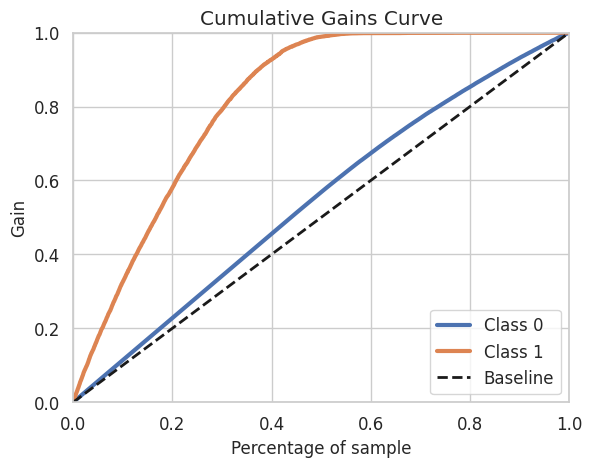

In [420]:
skplt.metrics.plot_cumulative_gain(y_test, ytest_xgb)

## 9.2 Lift Curve

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

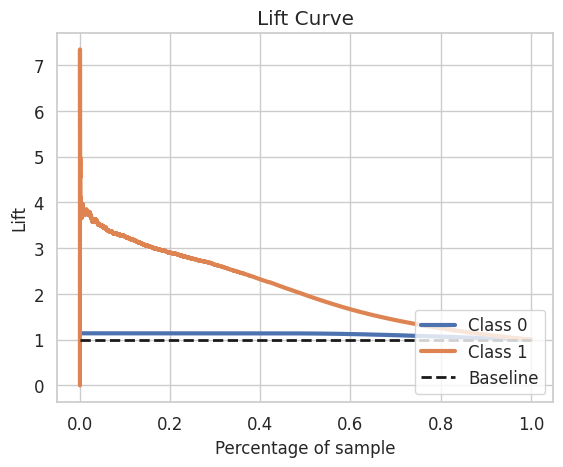

In [421]:
skplt.metrics.plot_lift_curve(y_test, ytest_xgb)


## 9.3 Impacto Econômico

In [422]:
x_teste = x_test.copy()
x_teste['id'] = df_test['id'].copy()
x_teste['score'] = ytest_xgb[:,1]
x_teste = x_teste.sort_values(by='score', ascending=False)

In [423]:
estimated_insurance = 600.00
cost_call = 50.00

In [424]:
x_teste['estimated_profit'] = x_teste['score']*estimated_insurance - cost_call
x_teste['cumulative_profit'] = x_teste['estimated_profit'].cumsum()

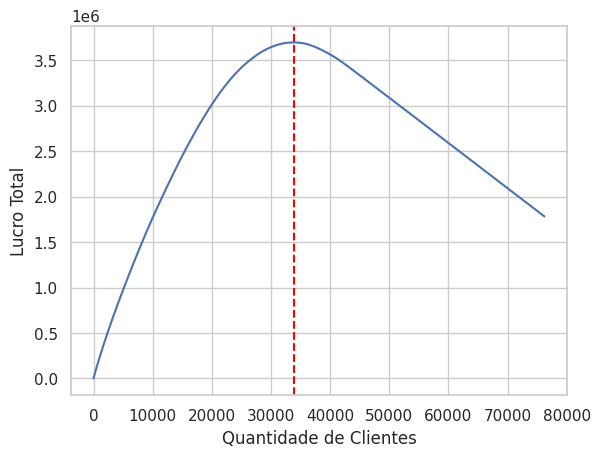

In [425]:
posicoes = np.arange(len(x_test)) + 1
plt.plot(posicoes, x_teste['cumulative_profit'])

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Lucro Total')

indice_maximo = np.argmax(x_teste['cumulative_profit'])
x_maximo = posicoes[indice_maximo]
y_maximo = x_teste['cumulative_profit'].iloc[indice_maximo]
# Adicionar linha vertical até o eixo x
plt.axvline(x=x_maximo, ymin=0, ymax=y_maximo / np.max(x_teste['cumulative_profit']), color='red', linestyle='--')


In [427]:
print(f'Quantidade Ideal da base de clientes para ligar: {100*round(x_maximo/x_teste.shape[0],2):.2f}%')
print(f'Lucro Total ligando para 100% Clientes: R${round(x_teste["cumulative_profit"].iloc[76221]):.2f}')
print(f'Lucro Total ligando para 44% Clientes: R${round(y_maximo):.2f}')

Quantidade Ideal da base de clientes para ligar: 44.00%
Lucro Total ligando para 100% Clientes: R$1782302.00
Lucro Total ligando para 44% Clientes: R$3696372.00


# 10.0 Deploy Model To Production

## 10.1 Classe Health Insurance

In [53]:
import pickle
import inflection

class HealthInsurance (object):
    def __init__(self):
        self.mms_vintage = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/mms_vintage.pkl', 'rb'))
        self.mms_age = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/mms_age.pkl', 'rb'))
        self.ss = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/ss.pkl', 'rb'))
        self.frequency_gender = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/frequency_gender.pkl', 'rb'))
        self.target_encode_policy_sales = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/target_encode_policy_sales.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/target_encode_region_code.pkl', 'rb'))
        self.target_encode_vehicle_age = pickle.load(open('/home/tiagobarreto/DS/repos/health-insurance1/src/features/target_encode_vehicle_age.pkl', 'rb'))
    
    def data_cleaning(self, df1):
        # rename columns
        cols_old = list(df1.columns)
        cols_new = [inflection.underscore(col) for col in cols_old]
        df1.columns = cols_new

        return df1
    
    def feature_engineering(self, df2):
        # feature engineering
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')
    
        return df2

    def data_preparation(self, df5):
        # standartization
        df5['annual_premium'] = self.ss.fit_transform(df5[['annual_premium']].values)

        # rescaling
        df5['age'] = self.mms_age.fit_transform(df5[['age']].values)
        df5['vintage'] = self.mms_vintage.fit_transform(df5[['vintage']].values)

        # encoding       
        df5['gender'] = df5['gender'].map(self.frequency_gender)

        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code)

        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.target_encode_policy_sales)

        df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(self.target_encode_vehicle_age)
        df5['vehicle_age'] = df5['vehicle_age'].astype(float)

        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code','policy_sales_channel', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender']

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):   

        result_data = original_data.copy()
        # prediction
        pred = model.predict_proba(test_data)
        result_data['Percentage'] = pred[:, 1]
        result_data = result_data.sort_values('Percentage', ascending = False)

        return result_data.to_json(orient = 'records', date_format = 'iso')


## 10.2 API Handler


In [50]:
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance
import pickle 

# loading model
model = pickle.load( open('/home/tiagobarreto/DS/repos/health-insurance1/src/model/model_health_insurance.pkl', 'rb'))

app = Flask(__name__)

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # Multiple Examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )
        
        # copy test_raw
        test_raw_inicial = test_raw.copy()

        # instantiate Health Insureance Class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw_inicial, df3)

        return df_response
    
    else:
        return Response('{}', status = 200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug = True )

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.6:5000
Press CTRL+C to quit
 * Restarting with stat
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


NOTE: When using the `ipython kernel` entry point, Ctrl-C will not work.

To exit, you will have to explicitly quit this process, by either sending
"quit" from a client, or using Ctrl-\ in UNIX-like environments.

To read more about this, see https://github.com/ipython/ipython/issues/2049


To connect another client to this kernel, use:
    --existing kernel-v2-930NrwvfD1w9R5R.json


In [9]:
import requests
import json
import pandas as pd

# loading test dataset
df10 = pd.read_csv('/home/tiagobarreto/DS/repos/health-insurance1/dataset/test.csv')
df_testando = df10.sample(10000) 

# convert DataFrame to json
data = json.dumps(df_testando.to_dict( orient='records' ) )

# API Call
# url = 'http://localhost:5000/predict'
url = 'https://health-insurance-api-6c2o.onrender.com/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post(url, data= data, headers = header)
print('Status Code {}'.format (r.status_code))

d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

Status Code 200
